In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir tres niveles desde tfm/teams/lille/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
# Temporada 22/23
# Baleba (Lille, 478 min) añadido como exógeno
# Bentaleb (Angers, 2489 min) en el pool
SEASON = '2223'
MIN_MINUTES = 800  # Estándar

# COLORES DISTINTOS
BALEBA_COLOR = '#DC143C'   # Crimson (Lille)
BENTALEB_COLOR = '#228B22' # ForestGreen (Angers)

MF_PLAYERS = [
    {'name': 'Carlos Baleba', 'search': 'Baleba', 'pos': 'MF', 'team': 'Lille', 'season': '2223'},
    {'name': 'Nabil Bentaleb', 'search': 'Bentaleb', 'pos': 'MF', 'team': 'Angers', 'season': '2223'},
]

SAVE_PATH_BASE = "./baleba_bentaleb_radars/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Conexión BD - Temporada 22/23
db = get_db_manager()

query_domestic = text("""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_domestic p
WHERE p.season = :season
""")

with db.engine.connect() as conn:
    df_raw = pd.read_sql(query_domestic, conn, params={'season': SEASON})

print(f"Extraídos pool 22/23: {df_raw.shape[0]} registros")

2026-01-18 15:02:10,417 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-18 15:02:10,883 - database.connection - INFO - Database connection successful


Extraídos pool 22/23: 2801 registros


In [4]:
# Filtrar por minutos mínimos Y posición MF
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('MF', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + MF: {df_filtered.shape[0]} jugadores")
print(f"\nLigas incluidas:")
print(df_filtered['league'].value_counts())

Filtro 800+ min + MF: 750 jugadores

Ligas incluidas:
league
ESP-La Liga           166
FRA-Ligue 1           165
ENG-Premier League    141
ITA-Serie A           140
GER-Bundesliga        138
Name: count, dtype: int64


In [5]:
# Añadir Baleba como exógeno (478 min < 800 min threshold)
baleba_row = df_raw[
    (df_raw['player_name'].str.contains('Baleba', case=False, na=False)) &
    (df_raw['team'].str.contains('Lille', case=False, na=False)) &
    (df_raw['season'] == '2223')
].copy()

if len(baleba_row) > 0:
    print(f"Añadiendo Baleba como exógeno:")
    for _, p in baleba_row.iterrows():
        minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
        print(f"  {p['player_name']} ({p['team']}, {minutes} min)")
    
    df_filtered = pd.concat([df_filtered, baleba_row], ignore_index=True)
    print(f"Pool actualizado: {df_filtered.shape[0]} jugadores")
else:
    print("ERROR: Baleba no encontrado en df_raw")

Añadiendo Baleba como exógeno:
  Carlos Baleba (Lille, 478.0 min)
Pool actualizado: 751 jugadores


In [6]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [7]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [8]:
# Métricas a excluir de normalización
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches',
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id', 
    'CS%', 'CS', 'PSxG+/-', 'PSxG', 'Save_Save%',
    "Sweeper_#OPA", 'Sweeper_#OPA/90', 'Sweeper_AvgDist', "Goal Kicks_Launch%", 'G-xG'
}

# Calcular per100touches FBref
fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

# Calcular per100touches Understat
understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches: {fbref_per100.shape[1]} + {understat_per100.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per100, understat_per100], axis=1)

Per100touches: 144 + 7


In [9]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 346
Percentiles totales: 346


In [10]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 751 filas, 698 columnas
Limpieza completada: 696 columnas finales


In [11]:
# Search MF players
player_ids = {}

print("PIVOTE PLAYER SEARCH:")
print("=" * 50)

for player_config in MF_PLAYERS:
    player_name = player_config['name']
    search_pattern = player_config['search']
    target_season = player_config['season']
    
    search_results = df_filtered[
        (df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)) &
        (df_filtered['season'] == target_season)
    ]
    
    if len(search_results) > 0:
        print(f"\n{player_name} - search: '{search_pattern}' (season {target_season}):")
        for _, p in search_results.iterrows():
            minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['season']}) - {minutes} min")
            
            if player_name not in player_ids:
                player_ids[player_name] = p['unique_player_id']
                print(f"  ✓ ASSIGNED: {player_name} -> {p['unique_player_id']}")
                break
    else:
        print(f"\n{player_name}: NOT FOUND in season {target_season}")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

if len(player_ids) == 2:
    print(f"\n✓ ALL PLAYERS FOUND")
else:
    print(f"\n✗ MISSING PLAYERS")

PIVOTE PLAYER SEARCH:

Carlos Baleba - search: 'Baleba' (season 2223):
  f78eb44040a1bfde - Carlos Baleba (Lille, FRA-Ligue 1, 2223) - 478.0 min
  ✓ ASSIGNED: Carlos Baleba -> f78eb44040a1bfde

Nabil Bentaleb - search: 'Bentaleb' (season 2223):
  ee0c963766e4e66c - Nabil Bentaleb (Angers, FRA-Ligue 1, 2223) - 2489.0 min
  ✓ ASSIGNED: Nabil Bentaleb -> ee0c963766e4e66c

PLAYERS FOUND:
  Carlos Baleba: f78eb44040a1bfde
  Nabil Bentaleb: ee0c963766e4e66c

✓ ALL PLAYERS FOUND


In [12]:
# PIVOTE metrics configuration (del template)
pivote_metrics = [
    'pass_completion_pct', 'progressive_passes_per100touches', 'Tkl+Int_per100touches', 'interceptions_per100touches',
    'Challenges_Tkl%', 'Carries_PrgC_per100touches', 'SCA_SCA90', 'Recov_per100touches',
    'Fld_per100touches', 'expected_assists_per100touches'
]
pivote_titles = [
    'Pass Accuracy %', 'Progressive Passes', 'Tackles + Interceptions', 'Interceptions',
    'Tackle Success %', 'Progressive Carries', 'Shot Creating Actions', 'Recoveries',
    'Fouls Drawn', 'Expected Assists'
]

METRICS_BY_POSITION = {
    'pivote': {'metrics': pivote_metrics, 'titles': pivote_titles}
}

print("PIVOTE METRICS VERIFICATION:")
print("=" * 50)
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

PIVOTE METRICS VERIFICATION:
OK pivote: 10 metrics, 10 titles


In [13]:
# Baleba vs Bentaleb comparison configuration
# Colores distintos para diferenciar
COMPARISON = {
    'name': 'Baleba_vs_Bentaleb',
    'player1': 'Carlos Baleba',
    'player2': 'Nabil Bentaleb', 
    'position_type': 'MF_PIVOTE',
    'metrics_key': 'pivote',
    'title': 'Carlos Baleba (Lille) vs Nabil Bentaleb (Angers) 22/23',
    'faces': ['/home/jaime/FD/data/blog/caras/tfm/baleba.png', '/home/jaime/FD/data/blog/caras/tfm/bentaleb.png'],
    'colors': [BALEBA_COLOR, BENTALEB_COLOR]  # Crimson vs ForestGreen
}

print(f"COMPARISON: {COMPARISON['title']}")
print(f"Colors: {COMPARISON['colors']}")

COMPARISON: Carlos Baleba (Lille) vs Nabil Bentaleb (Angers) 22/23
Colors: ['#DC143C', '#228B22']


PIVOTE PLAYER RADAR GENERATION

Processing: Carlos Baleba (Lille) vs Nabil Bentaleb (Angers) 22/23
  Dataset: 751 players (MF, 22/23)
  Teams: Lille vs Angers
  Colors: ['#DC143C', '#228B22']
  ✓ Completed: Baleba_vs_Bentaleb_combined.png


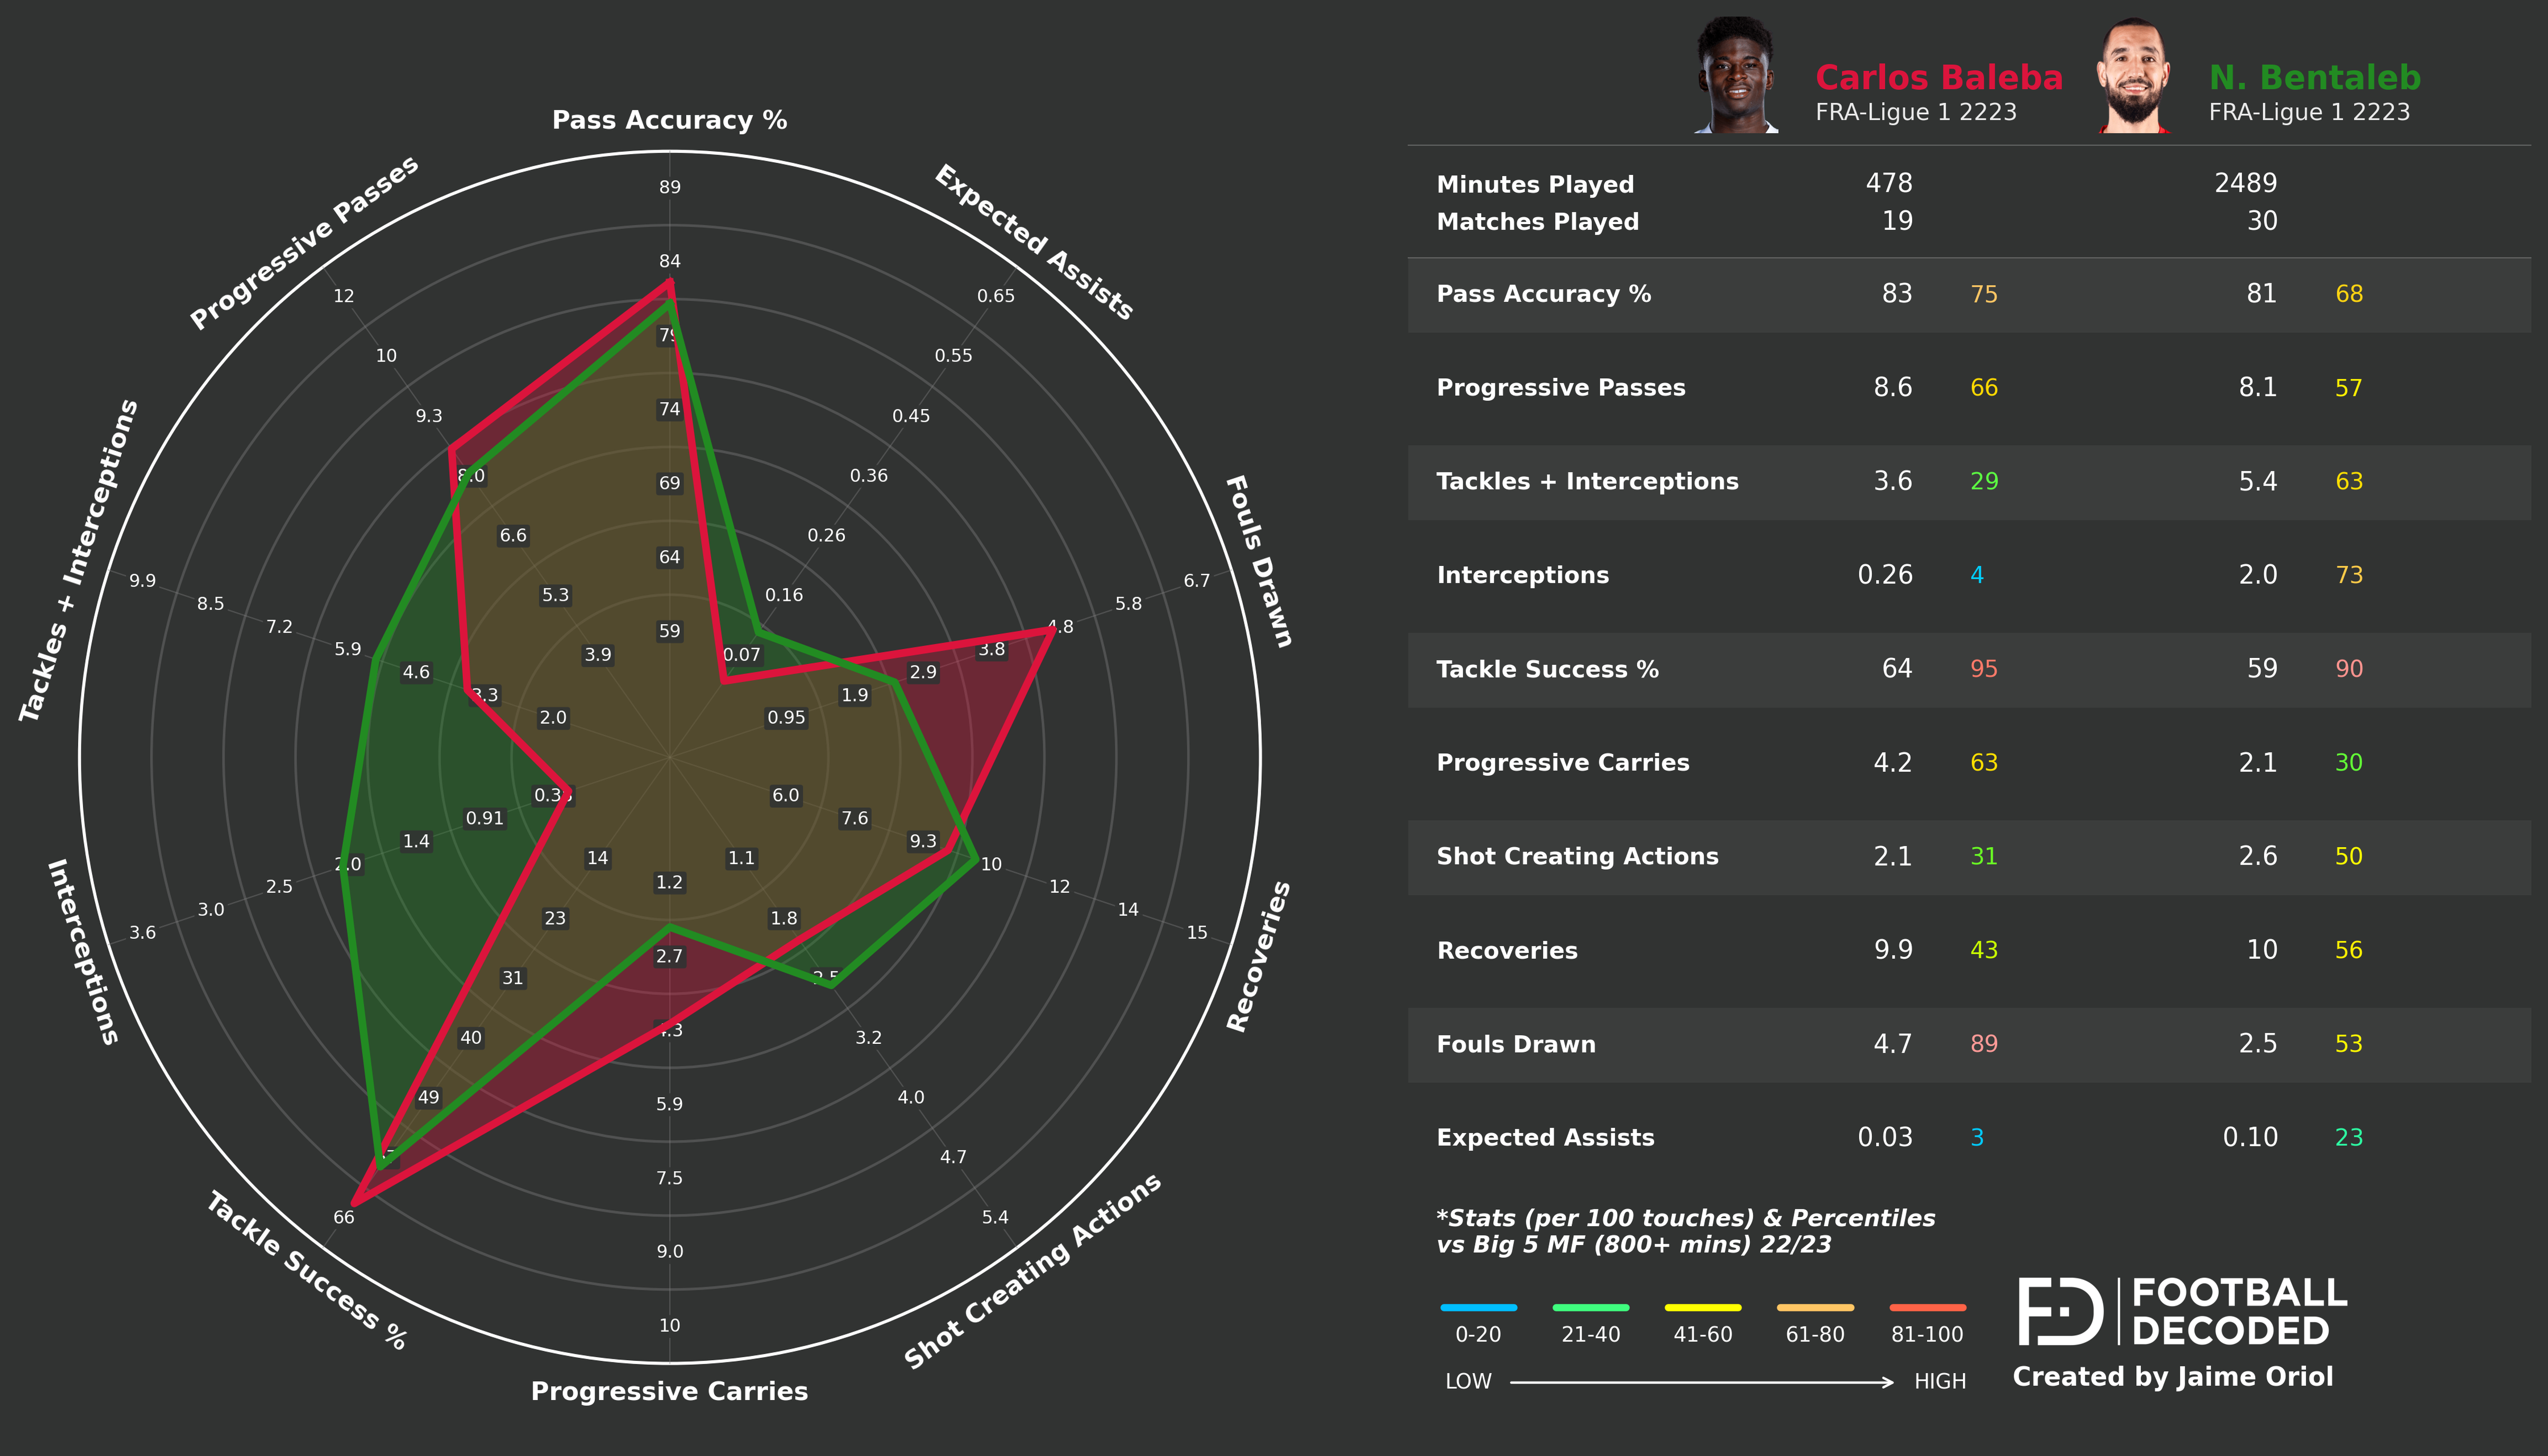


RADAR COMPARISON SUMMARY
✓ Radar generated successfully
Files saved in: ./baleba_bentaleb_radars/


In [14]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("PIVOTE PLAYER RADAR GENERATION")
print("=" * 50)

comparison = COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']
metrics_key = comparison['metrics_key']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    metrics_config = METRICS_BY_POSITION[metrics_key]
    metrics = metrics_config['metrics']
    metric_titles = metrics_config['titles']
    
    # Dataset MF
    position_df = df_final[df_final['position'].str.contains('MF', case=False, na=False)].copy()
    position_filter = "MF"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter}, 22/23)")
    
    # Team names
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {}
    if faces[0]:
        team_logos[player1_team] = faces[0]
    if len(faces) > 1 and faces[1]:
        team_logos[player2_team] = faces[1]
    
    print(f"  Teams: {player1_team} vs {player2_team}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (per 100 touches) & Percentiles\nvs Big 5 {position_filter} ({MIN_MINUTES}+ mins) 22/23",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
        print("\n" + "=" * 50)
        print("RADAR COMPARISON SUMMARY")
        print("=" * 50)
        print(f"✓ Radar generated successfully")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()